In [12]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.cbam import CBAMResNet
from torchvision import transforms

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [4]:
artifact_path = Path("../../artifacts/cbam")
data_path = Path("../../data/animal10")

In [5]:
device = torch.device("cuda:0")

# data

In [6]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [7]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [8]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [9]:
num_class = len(dataset.classes)

# model

In [10]:
model = CBAMResNet(output_size=num_class, key=50).to(device)

In [11]:
torchinfo.summary(model)

Layer (type:depth-idx)                                       Param #
CbamResNet                                                   --
├─Sequential: 1-1                                            --
│    └─ConvBnRelu: 2-1                                       --
│    │    └─Conv2d: 3-1                                      9,408
│    │    └─BatchNorm2d: 3-2                                 128
│    │    └─ReLU: 3-3                                        --
│    └─MaxPool2d: 2-2                                        --
├─Sequential: 1-2                                            --
│    └─ResBlock: 2-3                                         --
│    │    └─BottleNeck: 3-4                                  66,675
│    │    └─ConvBnRelu: 3-5                                  16,896
│    └─ResBlock: 2-4                                         --
│    │    └─BottleNeck: 3-6                                  78,963
│    │    └─Identity: 3-7                                    --
│    └─ResBlock: 2-

# training

In [14]:
epoches = 10
acc_iters = 64 // BATCH_SIZE

In [15]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [17]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [18]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 1636/1636 [19:25<00:00,  1.40it/s]


epoch 1 : 0.025301675313359587


100%|██████████| 1636/1636 [07:50<00:00,  3.48it/s]


epoch 2 : 0.018290914501482507


100%|██████████| 1636/1636 [07:56<00:00,  3.43it/s]


epoch 3 : 0.015131842359800283


100%|██████████| 1636/1636 [07:50<00:00,  3.48it/s]


epoch 4 : 0.013030196234360702


100%|██████████| 1636/1636 [07:45<00:00,  3.51it/s]


epoch 5 : 0.011587034727328327


100%|██████████| 1636/1636 [07:18<00:00,  3.73it/s]


epoch 6 : 0.01046729177197562


100%|██████████| 1636/1636 [07:19<00:00,  3.72it/s]


epoch 7 : 0.009514206620704607


100%|██████████| 1636/1636 [07:19<00:00,  3.72it/s]


epoch 8 : 0.008913610624352955


100%|██████████| 1636/1636 [07:28<00:00,  3.65it/s]


epoch 9 : 0.008097603047742796


100%|██████████| 1636/1636 [07:25<00:00,  3.67it/s]

epoch 10 : 0.0073800331222946295


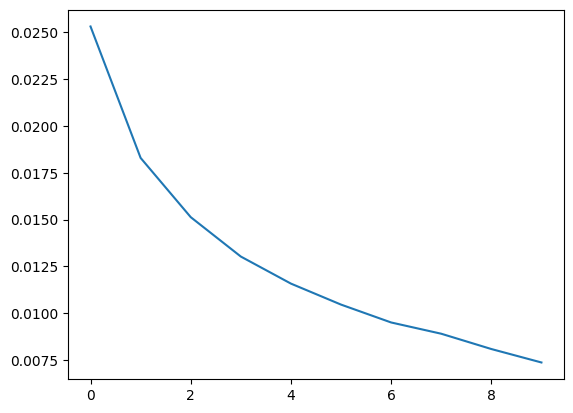

In [19]:
plt.plot(training_loss)

# inference

In [20]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [21]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [22]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [23]:
evaluator = ClassificationEvaluator(num_class, device)

In [24]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 1637/1637 [02:46<00:00,  9.84it/s]

[[4382  155   29   19   40   24   57   46   62   49]
 [ 111 2306   24    7   24    1  100   27   14    9]
 [  57   37 1238    5   10    0   41   26   13   19]
 [  16    7    7 1919    3    0    5    3  130   22]
 [ 100   23   12   26 2836    6    7   18   47   23]
 [ 381   16   12   29   16  980    9   22   89  114]
 [ 119  149   15    1   20    2 1471   74    6    9]
 [ 106   35   18    6   30    3  141 1449   17   15]
 [  35   10    5  147    9    2    5    9 4568   31]
 [  66    9   10   10   23    7    1   31   66 1639]]


In [25]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.901089862224964
cavallo   : 0.8791460160121998
elefante  : 0.8561549100968188
farfalla  : 0.9086174242424242
gallina   : 0.9154293092317625
gatto     : 0.5875299760191847
mucca     : 0.7883172561629154
pecora    : 0.7961538461538461
ragno     : 0.9475212611491391
scoiattolo: 0.8802363050483352


In [26]:
per_class_acc.mean()

0.8460196166341589

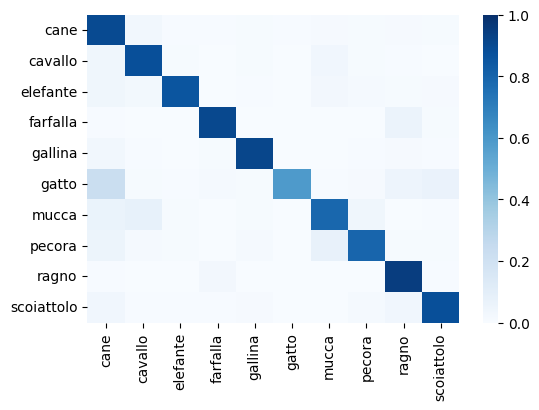

In [27]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [28]:
model_path = artifact_path / 'cbam-resnet50.pth'

In [29]:
torch.save(model.state_dict(), model_path)

In [30]:
get_file_size(model_path)

'99.77MB'

In [31]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>